## Monochromatic high-order harmonic generation by a Bessel-Gauss beam in periodically modulated media

As insisting on perfect phase matching within medium segments leads to unacceptably long targets, this nootebook allows relaxing this condition and specifying the phase mismatch gained inside the medium.

In [21]:
# general imports
import copy
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from IPython.display import display, Latex

# imports for analytical calculations
import XUV_refractive_index as XUV_index
import XUV_signal_computation2 as XUV_sig
import mynumerics as mn
import harmonic_signal as hs

### Set initial parameters here

In [22]:
# initial parameters
gas_type = 'Ar'
wavelength = 800 #nm - fundamental laser wavelength in nanometers
H_opt = 23# HHG order to be optimized

l1 = 0.4e-3 #m - medium segment length
periods = 11 # number of medium periods

mismatch = -np.pi/2 #rad - phase mismatch within medium segment
#mismatch = 0
n = 1 #multiple of 2*pi to be gained in phase at the end of one period

pressure = 60e-3 #bar
OPTIMIZE_PRESSURE = True #calculate optimal pressure to keep L_abs

L_abs_factor = 3. 
eta_factor = 0.25 #factor to multiply 'eta_opt' with

# auxiliary parameters
# tables to be used:
XUV_table_type_absorption = 'Henke' # {Henke, NIST}    
XUV_table_type_dispersion = 'Henke'


In [23]:
# helper variables and defitions

pressure_guess = 1e-3 #bar

omegaSI = mn.ConvertPhoton(wavelength*1e-9, 'lambdaSI', 'omegaSI') 

parameters = {'XUV_table_type_dispersion': XUV_table_type_dispersion,
              'XUV_table_type_absorption': XUV_table_type_absorption,
              'gas_type': gas_type,
              'omegaSI': omegaSI,
              'Aq' : 1.0}

eta_opt = XUV_sig.eta_opt(H_opt, parameters)
eta_gen = eta_factor*eta_opt

delta_phi = np.pi/(H_opt*n)

def asymptotic_signal(p,omega):
    return 4.*((p*parameters['Aq'])**2)*XUV_index.L_abs(omega, pressure, gas_type + '_' + XUV_table_type_absorption)**2

## Contrast as a function of the number of periods while keeping the total length of the medium $3L_{\mathrm{abs}}$

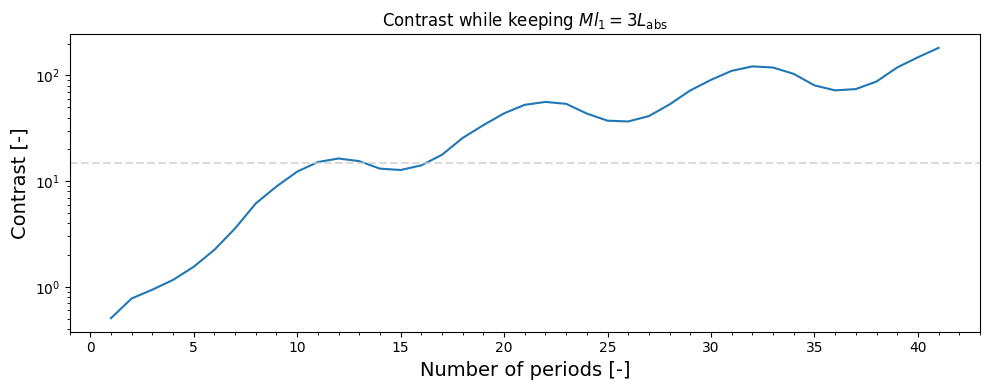

In [24]:
M_max = 2*H_opt

M_grid = np.arange(1, M_max)

H_interest = list(range(H_opt-6,H_opt+7,2))
H_compare = copy.deepcopy(H_interest)
H_compare.remove(H_opt)

pressure_grid = np.zeros((len(M_grid),))
zeta_opt = np.empty((len(M_grid),)); xi_opt = np.empty((len(M_grid),))
signal_list = []
contrasts = np.zeros((len(M_grid),))

for k1 in range(len(M_grid)):
    L_abs_p_f = lambda p: M_grid[k1]*l1 - L_abs_factor*XUV_index.L_abs(H_opt*omegaSI, p, gas_type + '_' + XUV_table_type_absorption)
    pressure_grid[k1] = sp.optimize.newton(L_abs_p_f, pressure_guess)
    # print(3*XUV_char.L_abs(gas_type + '_' + XUV_table_type_absorption, Horder_init*omegaSI, pressure_grid[k1]))
    zeta_opt[k1] = XUV_sig.zeta_single_segment_mismatch(pressure_grid[k1], H_opt, eta_gen, parameters, l1, mismatch)
    #xi_opt[k1] = XUV_sig.xi_opt_with_mismatch(pressure_grid[k1], l1, zeta_opt[k1], eta_gen, H_opt, parameters, mismatch, n)
    xi_opt[k1] = XUV_sig.xi_calc_pm(delta_phi,pressure_grid[k1], l1, zeta_opt[k1], eta_gen, H_opt, parameters)
    signal_list.append(
        [XUV_sig.periodic_medium_signal(pressure_grid[k1], zeta_opt[k1], l1, xi_opt[k1], eta_gen, H_calc, M_grid[k1], parameters)[1] for H_calc in H_interest]
        )
    
    contrasts[k1] = XUV_sig.monochrom_function(H_interest, signal_list[k1], H_opt, H_compare, metric='max')

signals = np.asarray(signal_list)
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("Number of periods [-]", fontsize=14)
ax.set_ylabel("Contrast [-]", fontsize=14)
ax.semilogy(M_grid, contrasts)
ax.axhline(y=15, color='0.8', linestyle='--', alpha=0.7)
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.set_title(r'Contrast while keeping $Ml_1 = 3L_{\mathrm{abs}}$') 

plt.tight_layout()
# fig.savefig('Contrast_keeping_3Labs.pdf')
plt.show()


pressure=14.3 mbar
zeta=2.8312660959337053e-05
theta_opt=7.525 mrad
xi=2.523
l1=0.4 mm
l2=1.01 mm
target_length=13.08 mm


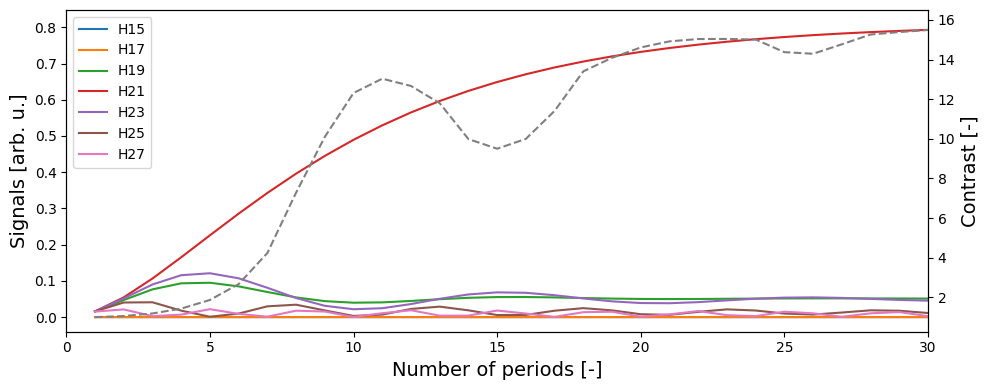

In [25]:
M_3Labs = periods

L_abs_p_f = lambda p: M_3Labs*l1 - L_abs_factor*XUV_index.L_abs(H_opt*omegaSI,
                p, gas_type + '_' + XUV_table_type_absorption)
if OPTIMIZE_PRESSURE:   
    pressure = sp.optimize.newton(L_abs_p_f, pressure_guess)

print(f'pressure={pressure*1e3:.1f} mbar')

zeta_opt = XUV_sig.zeta_single_segment_mismatch(pressure, H_opt, eta_gen, parameters, l1, mismatch)

theta_opt = XUV_sig.zeta2theta(zeta_opt)*1e3 #mrad
#xi_opt = XUV_sig.xi_opt_with_mismatch(pressure, l1, zeta_opt, eta_gen, H_opt, parameters, mismatch, n)
xi_opt = XUV_sig.xi_calc_pm(delta_phi,pressure, l1, zeta_opt, eta_gen, H_opt, parameters)
l2_opt = l1*xi_opt
print(f'zeta={zeta_opt}')
print(f'theta_opt={theta_opt:.3f} mrad')
print(f'xi={xi_opt:.3f}')
print(f'l1={l1*1e3} mm')
print(f'l2={l2_opt*1e3:.2f} mm')
print(f'target_length={((l1+l2_opt)*M_3Labs-l2_opt)*1e3:.2f} mm')

# signals
signal_list = [XUV_sig.periodic_medium_signal(pressure, zeta_opt, l1, xi_opt, 
                                              eta_gen, H_calc, M_grid, 
                                              parameters)[1] for H_calc in H_interest]


# plot signals
sig_norm = asymptotic_signal(pressure,H_opt*omegaSI)
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.set_xlabel("Number of periods [-]", fontsize=14)
ax1.set_ylabel("Signals [arb. u.]", fontsize=14)
for k1 in range(len(H_interest)):
    ax1.plot(M_grid, signal_list[k1]/sig_norm, label= r"H"+str(H_interest[k1]))

plt.legend()

ax2 = ax1.twinx()
ax2.set_ylabel("Contrast [-]", fontsize=14)
#ax2.semilogy(M_grid, 
#             XUV_sig.monochrom_function(H_interest, signal_list, H_opt, 
#            H_compare, metric='max'),
#            linestyle = '--', color = 'grey', label = 'contrast')

ax2.plot(M_grid, 
            XUV_sig.monochrom_function(H_interest, signal_list, H_opt, 
            H_compare, metric='max'),
            linestyle = '--', color = 'grey', label = 'contrast')

plt.xlim(0,30)

#ax.set_title("Reference case")

plt.tight_layout()
plt.show()

